# NVIDIA ARMA + GARCH Forecasting

In this notebook, we will construct both univariate and multivariate ARMA + GARCH models to forecast the daily log returns of NVIDIA stock

## Setup

In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import mplfinance as mpf
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
from Functions import tsPlot, candlestickPlot

Now we load in the time series data for and cut it down to a 5 year period for 2018 to 2023 and store it in the datafram called 'df'

In [2]:
# Read the csv file into a pandas DataFrame
df = pd.read_csv('../DataManagement/daily_data.csv', parse_dates=['DATE'], index_col='DATE')

# Specify the date range
start_date = '2018-06-30'
end_date = '2023-06-30'

# Slice the DataFrame for the desired date range
df = df.loc[start_date:end_date]

In [3]:
log_returns = df['NVDA_LOGRET'].copy()
exog_variables = df[['NVDA_EPS_SURPRISE', 'NVDA_EPS_EST', 'NVDA_EPS_ACT', 'NVDA_EARNINGS_FLAG']].copy()

log_returns.index = pd.DatetimeIndex(log_returns.index).to_period('D')
exog_variables.index = pd.DatetimeIndex(exog_variables.index).to_period('D')

Then we prepare a train/test split for the Nvidia log return series which we will use later for fitting and testing the ARMA and GARCH models. In this instance, we cut the last 60 days for testing and the rest is used for training.

In [4]:
train, test = log_returns[:-60], log_returns[-60:]
exog_train, exog_test = exog_variables[:-60], exog_variables[-60:]

In [5]:
month_year_formatter = mdates.DateFormatter('%Y-%m')
locator = mdates.MonthLocator(interval=3)

## Inspection

### Simple Daily Stock Price Plot

Below, we plot a simple time series graph of the daily adjusted close prices for Nvidia stock.

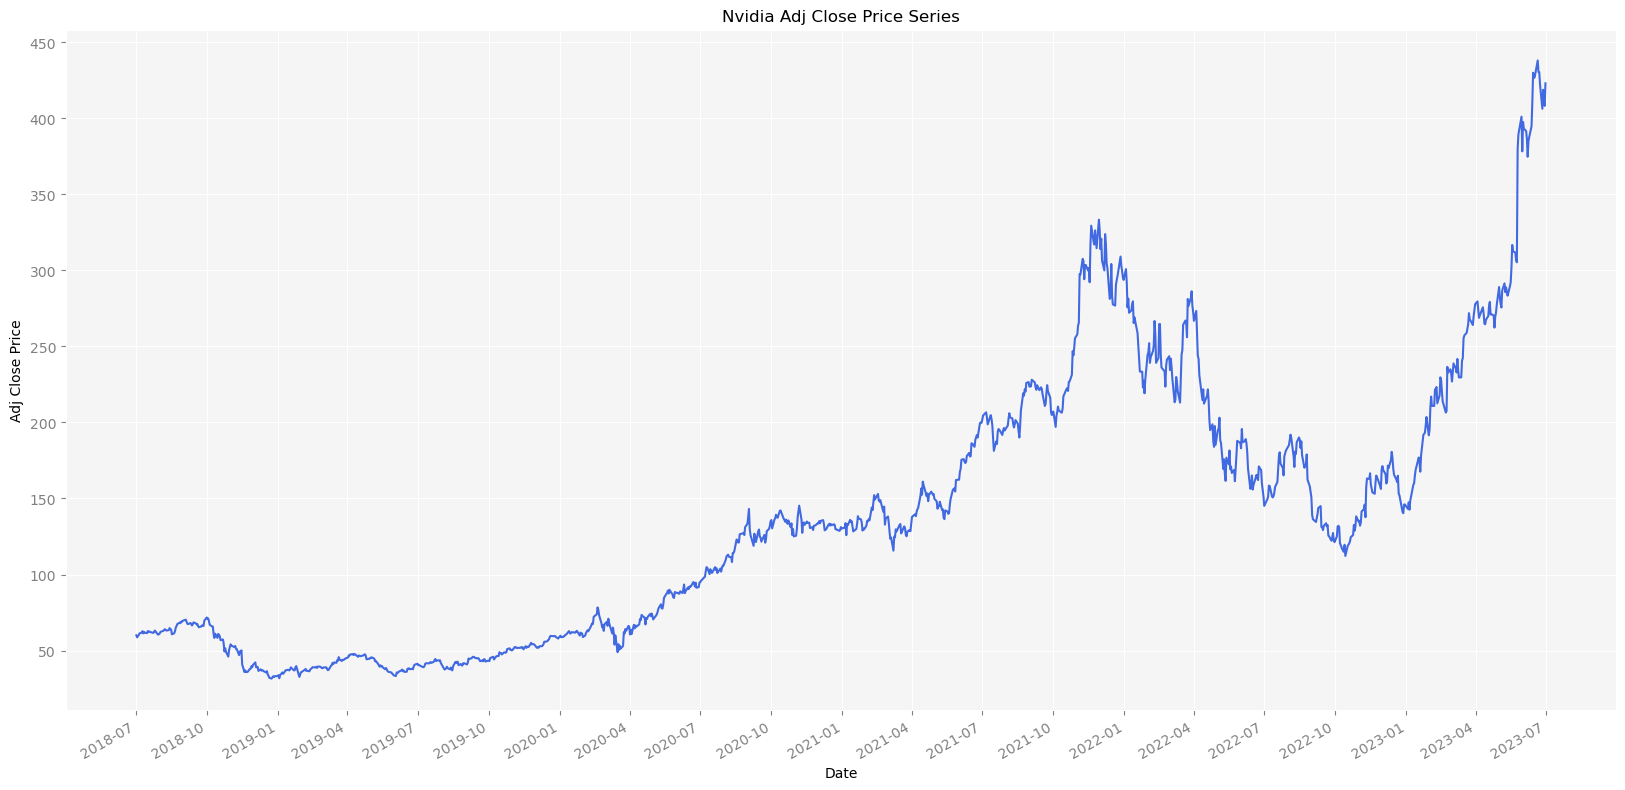

In [6]:
tsPlot(df['NVDA_CLOSE'], "Nvidia", "Adj Close Price")

### Daily Stock Price Candlestick Plot

Below, we plot the candlestick graph for the daily prices of Nvidia stock with moving averages over 10, 20 and 30 days and volume data on the lower part of the graph.

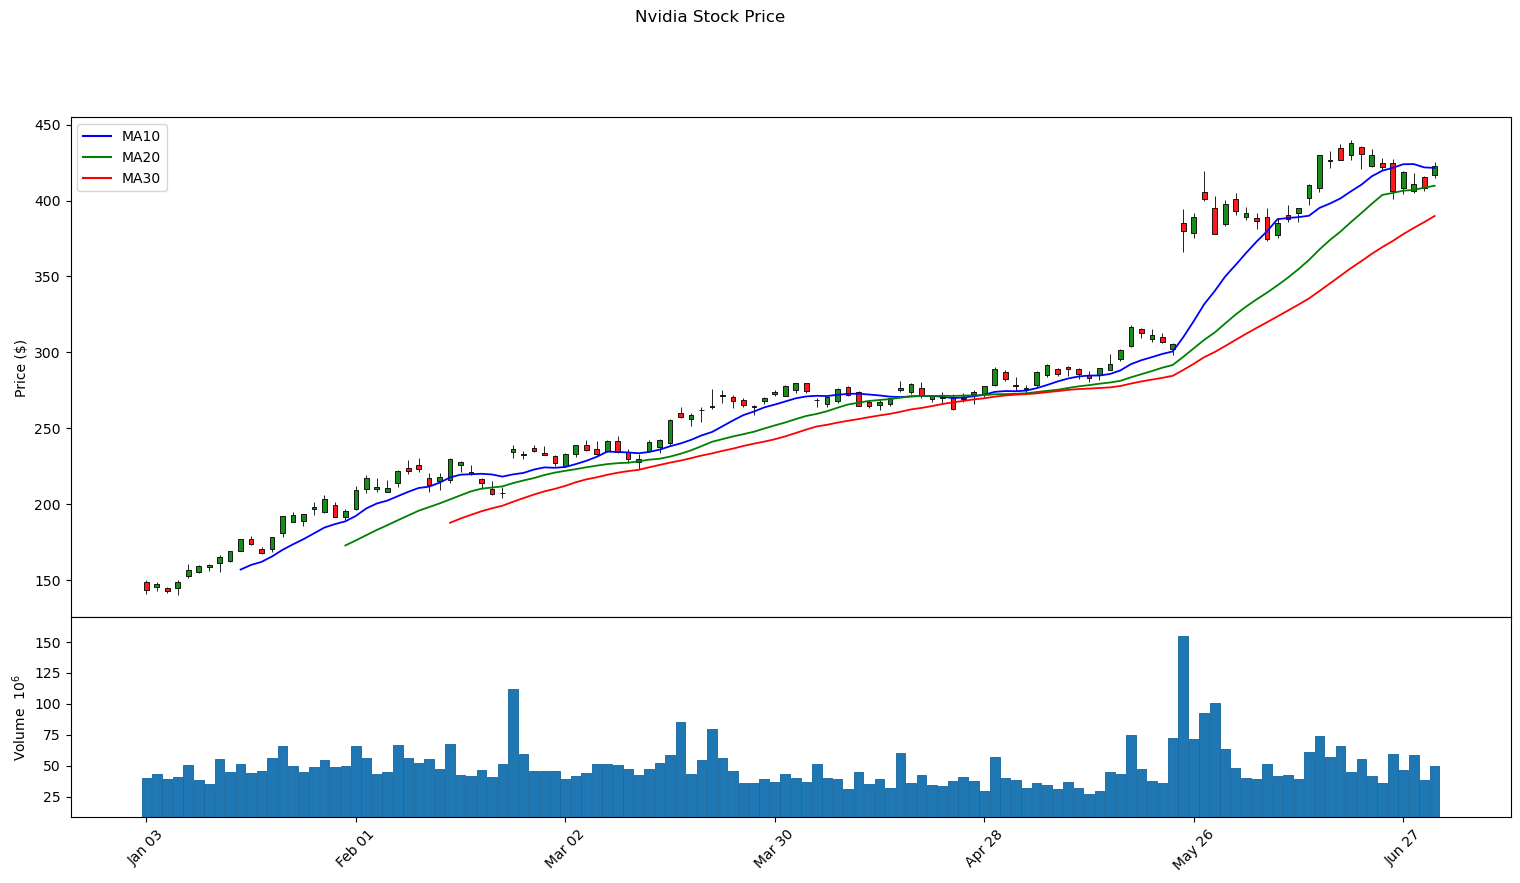

In [7]:
# Select only the NVDA columns
nvda_df = df[["NVDA_OPEN", "NVDA_HIGH", "NVDA_LOW", "NVDA_CLOSE", "NVDA_VOLUME"]]

# Slice the DataFrame for the desired date range
nvda_df = nvda_df.loc['2023-01-01':'2023-07-01']

# Rename columns to standard OHLC names
nvda_df.columns = ["Open", "High", "Low", "Close", "Volume"]

candlestickPlot(nvda_df, "Nvidia")

### Log Return Plot

Below, we plot the log returns for Nvidia stock

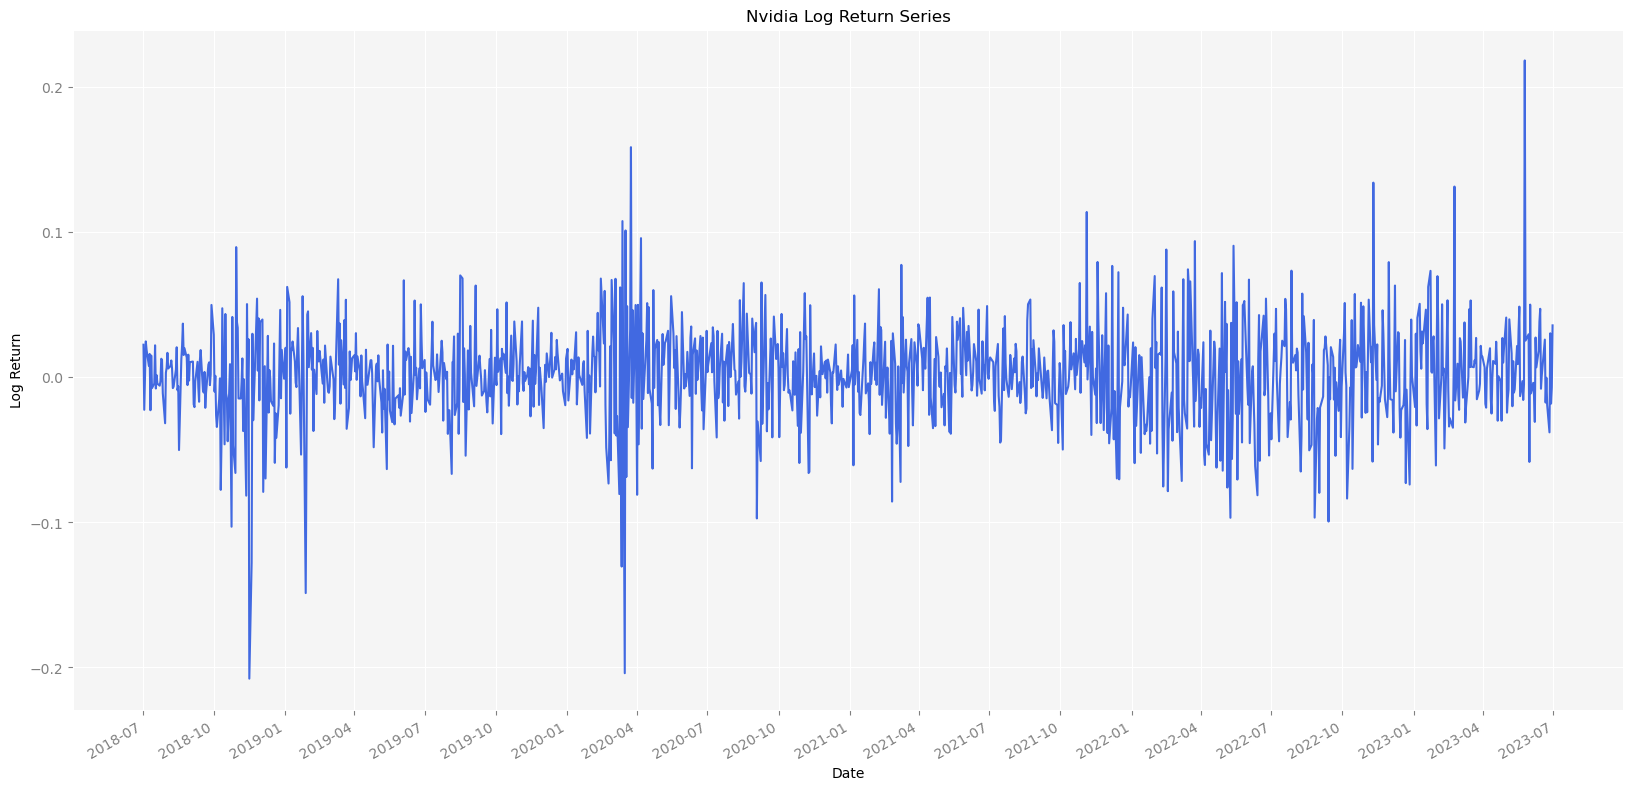

In [8]:
tsPlot(df['NVDA_LOGRET'], "Nvidia", "Log Return")

### Autocorrelation Function (ACF)

Here we generate the ACF from the squared log returns of Nvidia stock

The reasons for squaring the log returns are as follows:

* Variance Stabilization: By squaring the log returns, we transform the data and stabilize its variance. Financial time series data often exhibits heteroscedasticity, meaning that the volatility or variance of returns changes over time. Taking the log returns helps in normalizing the distribution of returns, but it does not address the changing variance. Squaring the log returns further stabilizes the variance and makes the data more suitable for analysis.

* Capturing Non-linear Dependencies: Squaring the log returns helps capture potential non-linear dependencies or patterns in the data. Linear autocorrelation measures, such as the standard ACF, are useful for detecting linear relationships between lagged observations. However, financial markets often exhibit complex and non-linear dynamics. Squaring the log returns can reveal nonlinear dependencies that might be missed by considering only linear relationships.

* Focus on Magnitude of Returns: In financial analysis, the magnitude of returns is often of interest. By squaring the log returns, we emphasize the magnitudes of returns and their relationships over time. This can be particularly relevant when studying market volatility, as extreme positive or negative returns can have significant implications.

* By squaring the log returns, we address the issues of variance stabilization, non-linear dependencies, and the focus on return magnitudes, providing a more comprehensive analysis of financial time series data. However, it is important to note that the decision to square log returns may depend on the specific objectives of the analysis and the characteristics of the data being studied.

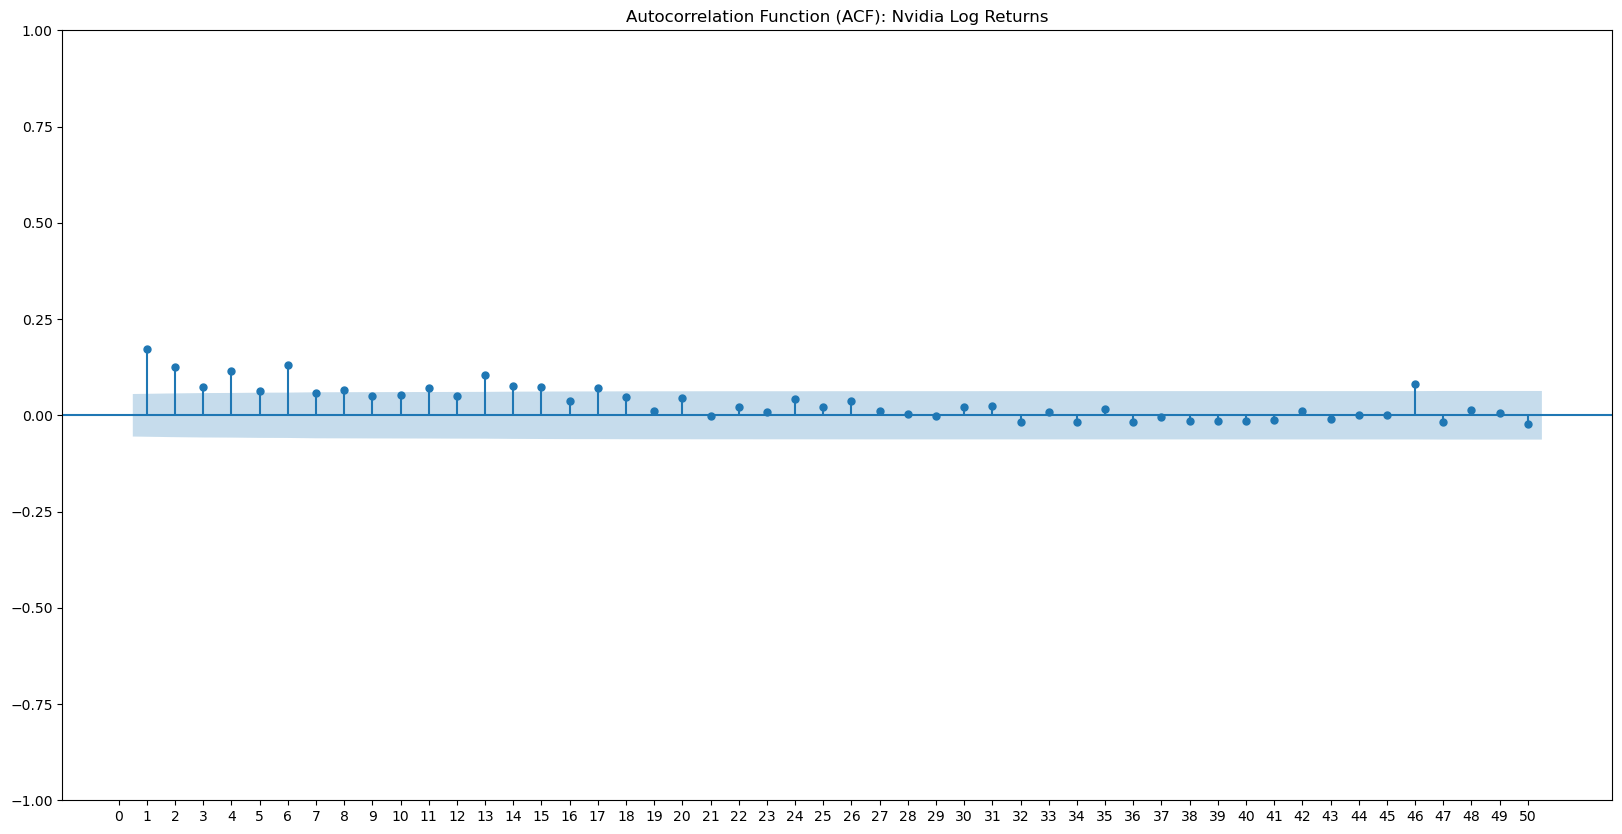

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
acf_plot = plot_acf(df['NVDA_LOGRET']**2, zero=False, lags=50, title='Autocorrelation Function (ACF): Nvidia Log Returns', ax=ax)

# Add more x-axis markers
ax.set_xticks(range(0, 51, 1))  # Set the positions of the markers
ax.set_xticklabels(range(0, 51, 1))  # Set the labels for the markers

plt.show()

Points that fall outside of the 95% confidence interval (blue region) can indicate the presence of statistically significant autocorrelations at the respective lags. We observe the most significant instances of this at lags of 2, 3, 5, 6 and 13. These observations will impact the decisions we make later on when fitting an ARMA model to the data in the following ways:

* Model Selection: The presence of statistically significant autocorrelations suggests that the time series has some degree of dependence on its past values. This implies that an ARMA model, which explicitly models the autocorrelation structure, may be appropriate for capturing the dynamics of the data. The identification of significant autocorrelations helps guide us towards considering an AR component (ARMA) or an MA component (ARMA) in the model.

* Lag Selection: The lags with statistically significant autocorrelations indicate the time points at which the past values of the series have a significant influence on the current value. These lags can guide the selection of appropriate lag orders for the AR and MA components of the ARMA model. For example, if there is a significant positive autocorrelation at lag 1, it suggests that the AR component may be relevant, and an AR lag of 1 could be included in the model.

* Model Specification: The identification of significant autocorrelations helps determine the appropriate orders (p, q) for the ARMA model. The parameter p represents the order of the autoregressive component, indicating the number of lagged values to include, while q represents the order of the moving average component, indicating the number of lagged errors to include. The statistically significant autocorrelations in the ACF plot can guide the selection of suitable values for p and q.

* Model Diagnostic Checking: After fitting an ARMA model, it is important to assess its adequacy and validity. The presence of statistically significant autocorrelations at lags not accounted for by the model (i.e., residuals showing autocorrelation) could indicate that the model does not fully capture the dynamics of the data. In such cases, further model refinement may be required, such as increasing the model order or considering alternative models.

The most important takeaway from this, however, is that the ACF will inform our decision for the 'q' parameter, or the 'MA' component, of our ARMA model.

### Partial Autocorrelation Function (PACF)

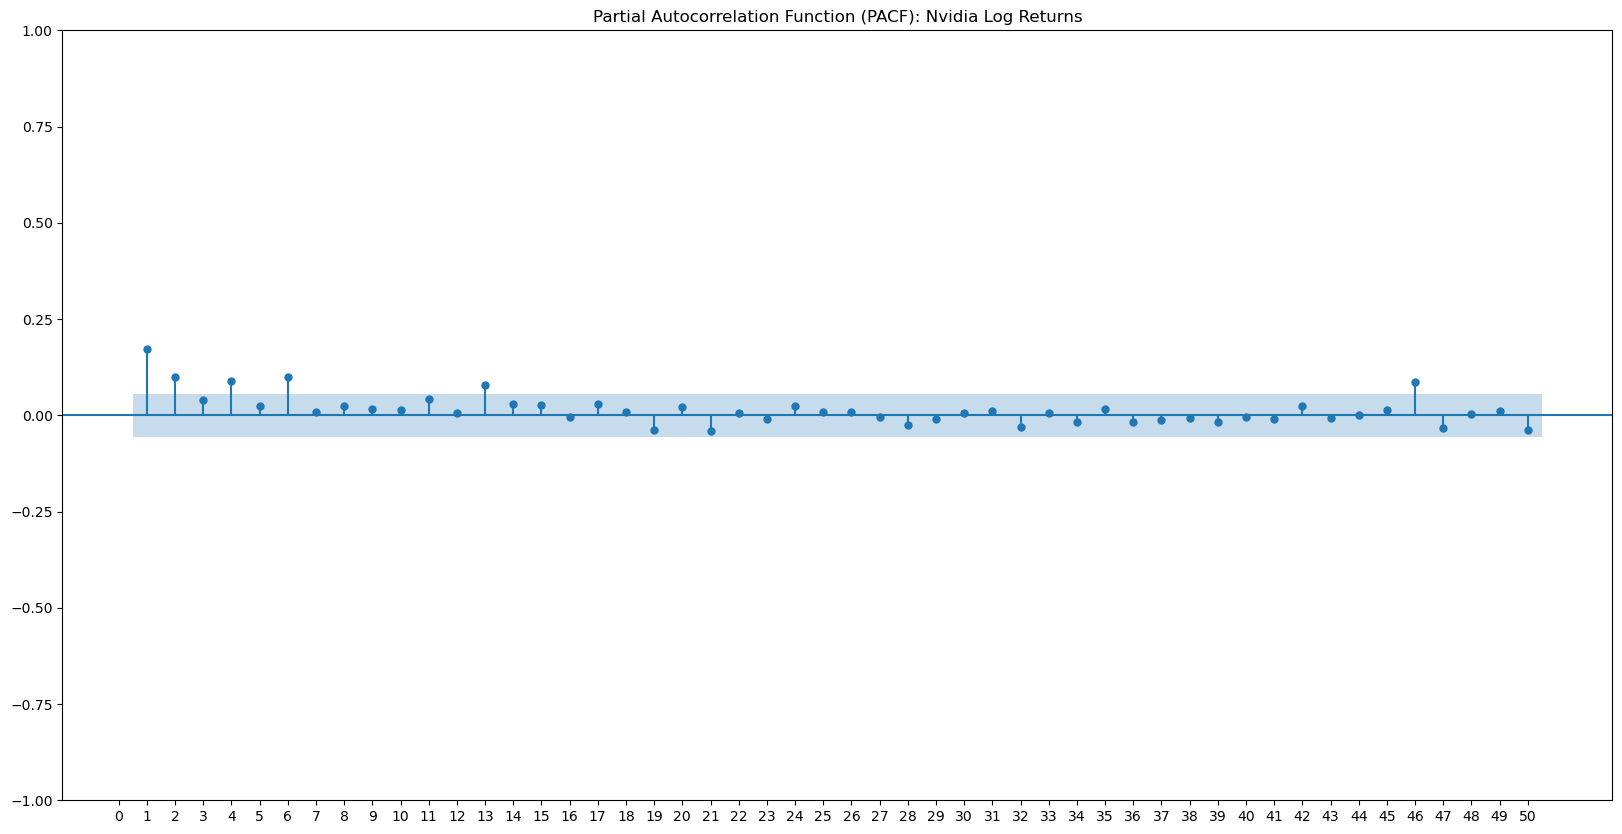

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
pacf_plot = plot_pacf(df['NVDA_LOGRET']**2, zero=False, lags=50, method='ywm', title='Partial Autocorrelation Function (PACF): Nvidia Log Returns', ax=ax)

# Add more x-axis markers
ax.set_xticks(range(0, 51, 1))  # Set the positions of the markers
ax.set_xticklabels(range(0, 51, 1))  # Set the labels for the markers

plt.show()

PACF Interpretation: The PACF measures the correlation between a time series and its lagged values while controlling for the effects of the intermediate lags. It provides a more direct measure of the relationship between the series and its lagged values. Key uses of the PACF include:

* Identifying the presence of significant partial autocorrelations at specific lags.
* Estimating the order of the Autoregressive (AR) component in an ARMA model.
* Determining the appropriate lag structure of the AR component, as it helps to isolate the direct influence of individual lags.

We observe the most signifiant autocorrelations at lags of 2, 3, 5 and 6

### Find Optimal ARMA Parameters

We use Akaike Information Criterion (AIC) combined with a grid search to identify the optimal parameters for our ARMA model.

In [11]:
%%capture
'''
# Define the maximum p and q for the ARMA model
max_p = 3
max_q = 3

# Initialise best AIC to a large value
best_aic = np.inf
best_arma_order = None

# Grid search for the optimal ARMA parameters
for p in range(max_p + 1):
    for q in range(max_q + 1):
        try:
            model = sm.tsa.ARIMA(train, order=(p, 0, q))
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_arma_order = (p, q)
        except:
            continue
'''
best_arma_order = (2,2)  # DELETE THIS IF GRID SEARCH IS UN-COMMENTED

In [12]:
print(f'Best ARMA order: {best_arma_order}')

Best ARMA order: (2, 2)


Now we fit a baseline ARMA model using these optimal parameters and extract the residuals for use in optimisiaing and fitting the GARCH model in the next stage

In [13]:
arma_base_model = sm.tsa.ARIMA(train, order=(2,0,2))
arma_base_res = arma_base_model.fit()

base_residuals = arma_base_res.resid

### Check Autocorrelations in ARMA Residuals

Next we plot a new ACF on the residuals of our base ARMA model to check that there are no statistically significant autocorrelations

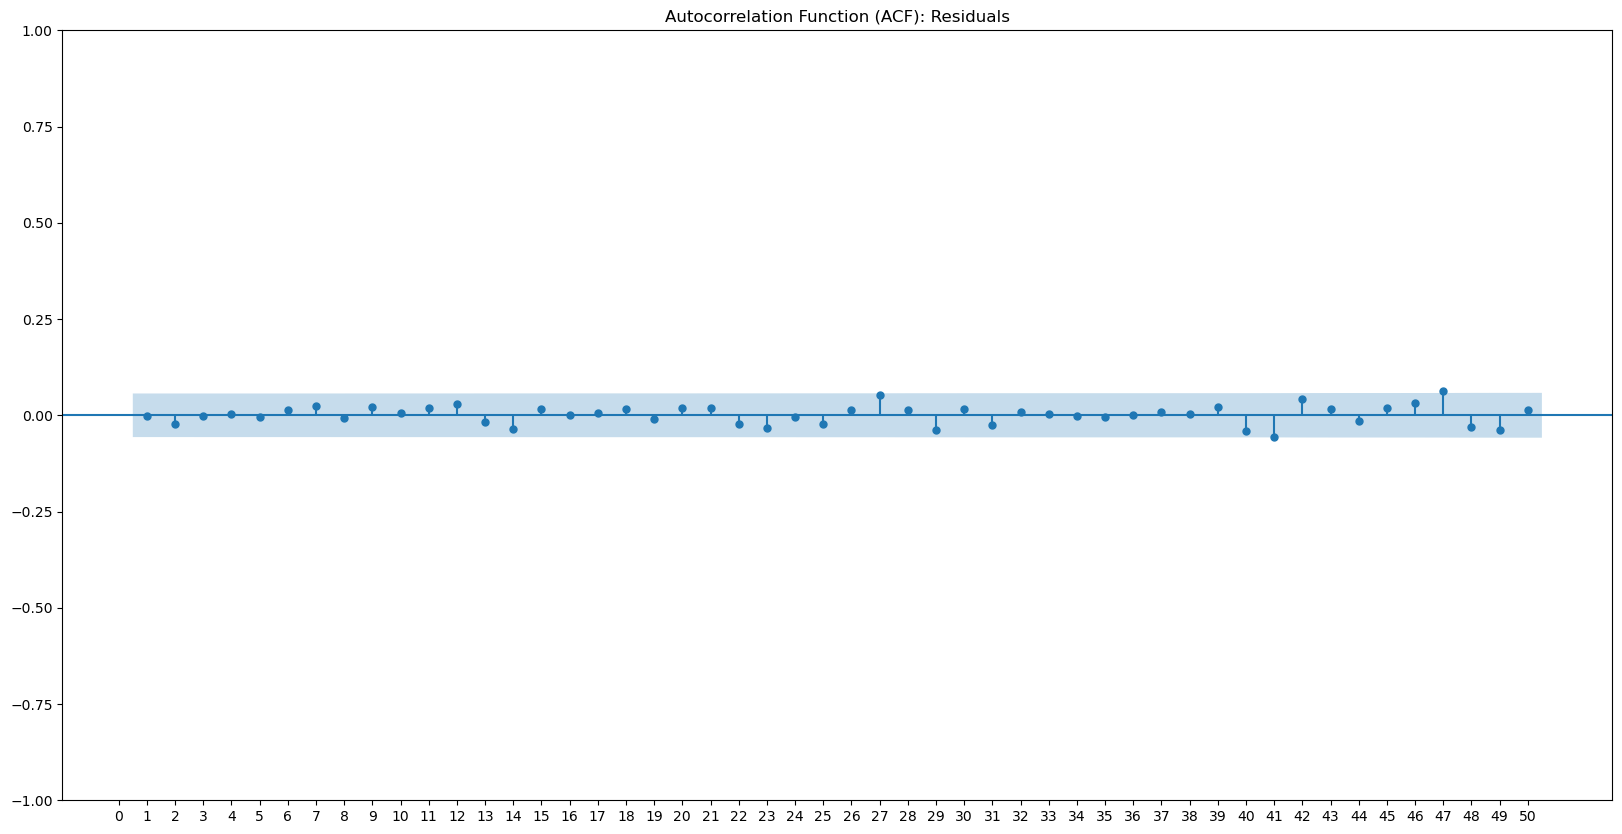

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
acf_plot = plot_acf(base_residuals, zero=False, lags=50, title='Autocorrelation Function (ACF): Residuals', ax=ax)

# Add more x-axis markers
ax.set_xticks(range(0, 51, 1))  # Set the positions of the markers
ax.set_xticklabels(range(0, 51, 1))  # Set the labels for the markers

plt.show()

Looking at the above ACF, it is clear that we have successfully achieved "white noise" or maximum entropy in the residuals of the ARMA model

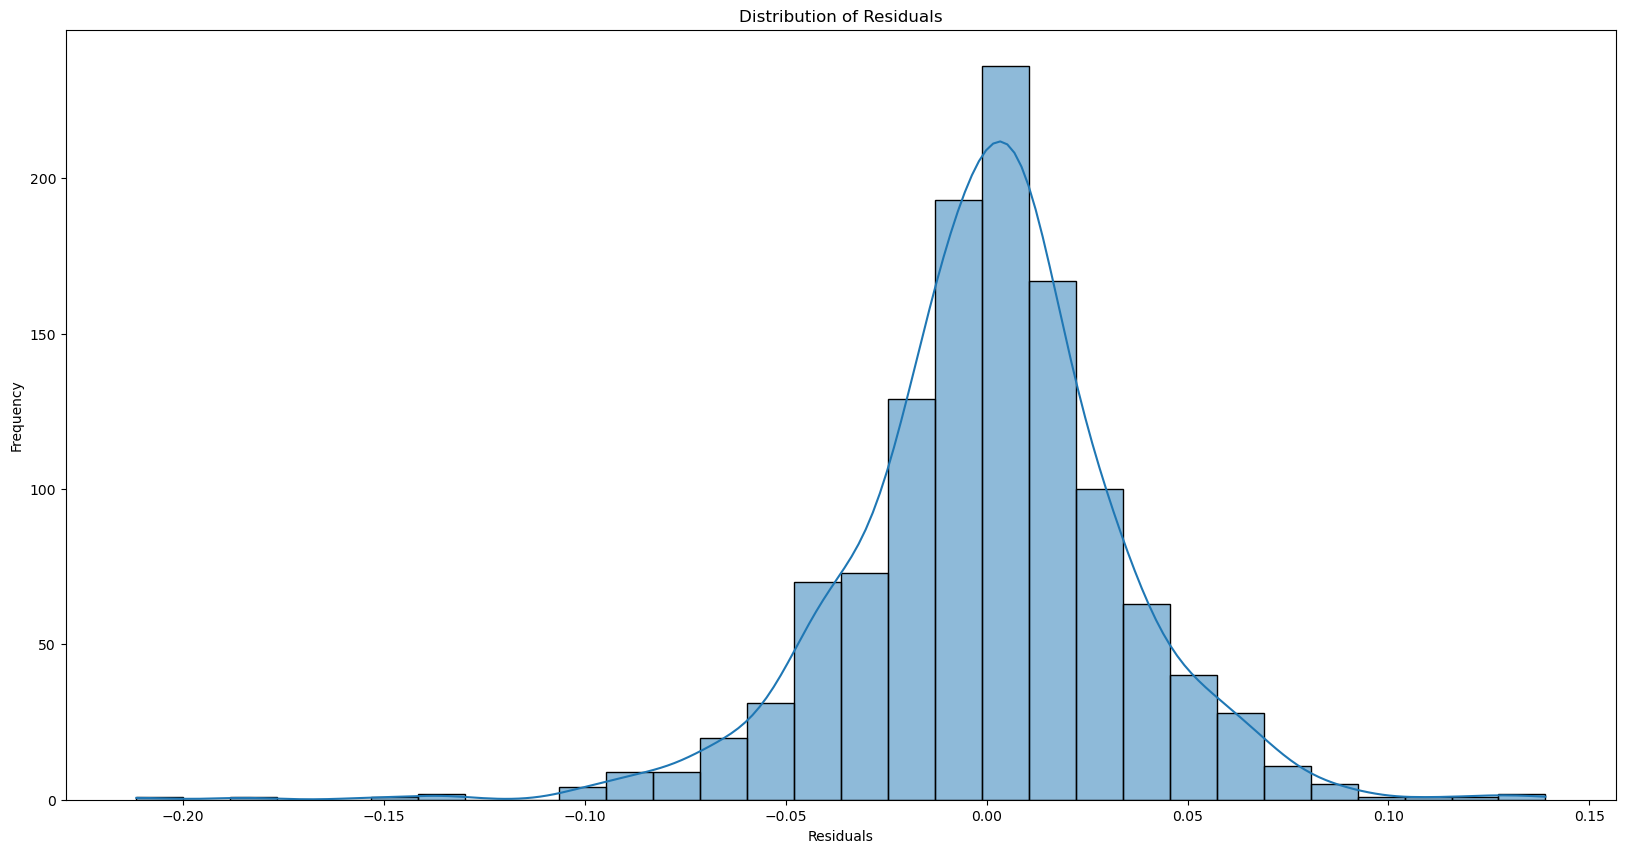

In [15]:
# Create the figure
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the histogram
sns.histplot(base_residuals, bins=30, kde=True, ax=ax)

# Add the title and labels
ax.set_title('Distribution of Residuals')
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')

# Show the plot
plt.show()

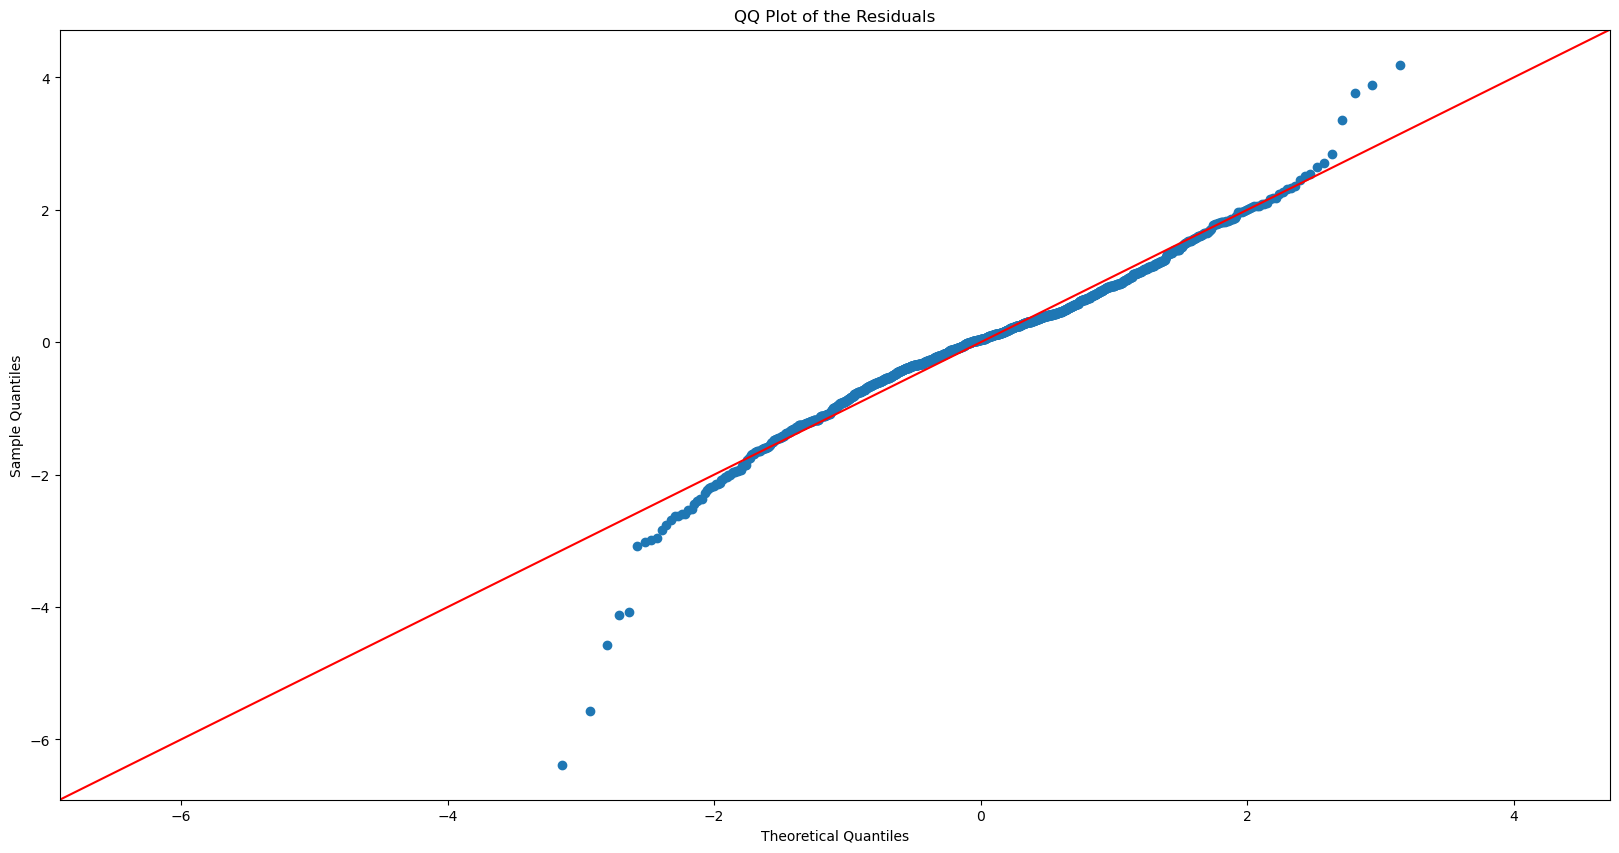

In [16]:
# Create the QQ plot
fig, ax = plt.subplots(figsize=(20, 10))
sm.qqplot(base_residuals, line='45', fit=True, ax=ax)

# Add the title
ax.set_title('QQ Plot of the Residuals')

# Show the plot
plt.show()

### Find Optimal GARCH Parameters

Similar to how we performed a grid search using the AIC to find the optimal ARMA parameters, we now perform the same procedure to find the optimal parameters for the GARCH model

Note: we are fitting garch with a student-t distribution in the hope that it better covers the fat tails that we observed in the previous QQ plot.
We also scale the arma residuals by 10x when fitting the garch model since this helps the algorithm to converge.

In [17]:
%%capture
'''
# Define the maximum p and q for the ARMA model
max_p = 2
max_q = 2

# Initialise best AIC to a large value
best_aic = np.inf
best_garch_order = None

# Grid search for the optimal ARMA parameters
for p in range(max_p + 1):
    for q in range(max_q + 1):
        try:
            model = arch_model(base_residuals*10, vol='Garch', p=p, q=q, dist='t')
            results = model.fit(update_freq=0)
            if results.aic < best_aic:
                best_aic = results.aic
                best_garch_order = (p, q)
                best_dist = d
        except:
            continue
'''
best_garch_order = (1,1)  # DELETE THIS IF GRID SEARCH IS UN-COMMENTED

In [18]:
print(f'Best GARCH order: {best_garch_order}')

Best GARCH order: (1, 1)


Now we perform some further analysis to check if the GARCH model sufficiently covers the residuals.

In [19]:
garch_base_model = arch_model(base_residuals*10, vol='Garch', p=best_garch_order[0], q=best_garch_order[1], dist='ged')
garch_base_res = garch_base_model.fit(update_freq=0)

# Standardised residuals
std_resid = garch_base_res.resid / garch_base_res.conditional_volatility

# Ljung-Box test
lb_test = acorr_ljungbox(std_resid, lags=10)  # Testing autocorrelation up to 10 lags
print(f'Ljung-Box test p-values: {lb_test}')

# ARCH-LM test
arch_lm = het_arch(std_resid)
print(f'ARCH-LM test p-value: {arch_lm[1]}')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 263.3518782833632
            Iterations: 11
            Function evaluations: 82
            Gradient evaluations: 11
Ljung-Box test p-values:      lb_stat  lb_pvalue
1   0.690364   0.406041
2   2.069514   0.355313
3   2.074620   0.557064
4   2.146463   0.708842
5   2.146695   0.828497
6   4.805157   0.569035
7   5.425856   0.608141
8   5.810098   0.668494
9   5.816870   0.758098
10  5.864816   0.826490
ARCH-LM test p-value: 0.4875919496027614


It looks like our GARCH model has fit the data fairly well.

* Ljung-Box test p-values: This is a test for autocorrelation in the residuals of a time series model. High p-values (greater than a typical significance level like 0.05) indicate that we do not reject the null hypothesis of no autocorrelation, which is desirable when checking the residuals of a time series model. In your case, all p-values are considerably higher than 0.05, suggesting that there's no evidence of remaining autocorrelation in the residuals, which is good.

* ARCH-LM test p-value: The ARCH-LM (Autoregressive Conditional Heteroskedasticity - Lagrange Multiplier) test is used to detect the presence of conditional heteroskedasticity. The null hypothesis is that there is no conditional heteroskedasticity. A high p-value (greater than a typical significance level like 0.05) means we do not reject the null hypothesis. The p-value of 0.4875919496027614 is greater than 0.05, suggesting that there's no evidence of remaining ARCH effects in the residuals, which is what we'd want after fitting a GARCH model.

* "Optimization terminated successfully (Exit mode 0)": This line indicates that the process of estimating your GARCH model was successful. In particular, "Exit mode 0" suggests that the algorithm used to optimize the model's parameters converged as intended.

Save the base (pre-test) ARMA and GARCH models.

In [20]:
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")

new_dir = dt_string
new_path_pre = '../Models/ArmaGarch/' + new_dir + '/PreTest/'
new_path_post = '../Models/ArmaGarch/' + new_dir + '/PostTest/'

os.makedirs(os.path.dirname(new_path_pre), exist_ok=True)
os.makedirs(os.path.dirname(new_path_post), exist_ok=True)

# Save ARMA model
with open(new_path_pre + 'arma_model.pkl', 'wb') as f:
    pickle.dump(arma_base_model, f)

# Save GARCH model
with open(new_path_pre + 'garch_model.pkl', 'wb') as f:
    pickle.dump(garch_base_model, f)

## ARMA and GARCH Model

### Fit Model

Initialise the lists for storing the forecasted and actual log returns as well as the 'data' list which will initially hold the training dataset but will have the actual data points added to it incrementally as we progress through the procedure.

In [21]:
# Initialise lists to store forecasts and actuals
forecasts_logret = []
actuals_logret = []

# Use the training data to fit the initial model
data = train.copy()

Now we loop over the test dataset, each time re-training the ARMA and GARCH model with the latest data at that point in time and making a new, one-day-ahead forecast.

There are also two main ways this can be implemented; expanding window and rolling window. Expanding window means simply expanding the "train" dataset at each iteration whilst rolling window means always training on the most recent "N" points. The code below uses an expanding window approach for now.

In [22]:
%%capture
for t in range(len(test)):
    # Fit the ARMA model to the data up to this point
    arma_model = sm.tsa.ARIMA(data, order=(best_arma_order[0], 0, best_arma_order[1]))
    arma_res = arma_model.fit()

    # Get the residuals from the ARMA model
    residuals = arma_res.resid

    # Fit the GARCH model on the residuals of the ARMA model
    garch_model = arch_model(residuals*10, vol='Garch', p=best_garch_order[0], q=best_garch_order[1], dist='ged')
    garch_res = garch_model.fit()

    # Make a one-step ahead forecast
    arma_forecast = arma_res.forecast(steps=1)
    garch_forecast = garch_res.forecast(start=0)

    # Re-scale the standard deviation of the GARCH forecast
    garch_variance_rescaled = garch_forecast.variance.copy() / 100  # We divide by 100 because variance is in squared units

    # Combine the forecasts
    combined_forecast = arma_forecast[0] + np.sqrt(garch_variance_rescaled.iloc[-1, :]) * np.random.normal(size=1)
    
    # Add the forecast to the list of forecasts
    forecasts_logret.append(combined_forecast[0])

    # Add the actual value to the list of actuals
    actuals_logret.append(test.iloc[t])
    
    # Add the new data point to the data
    data = pd.concat([data, test.iloc[t:t+1]])

Save the final ARMA and GARCH model.

In [23]:
# Save ARMA model
with open(new_path_post + 'arma_model.pkl', 'wb') as f:
    pickle.dump(arma_model, f)

# Save GARCH model
with open(new_path_post + 'garch_model.pkl', 'wb') as f:
    pickle.dump(garch_model, f)

Plot the forecasted vs actual log returns over the 60 day test period.

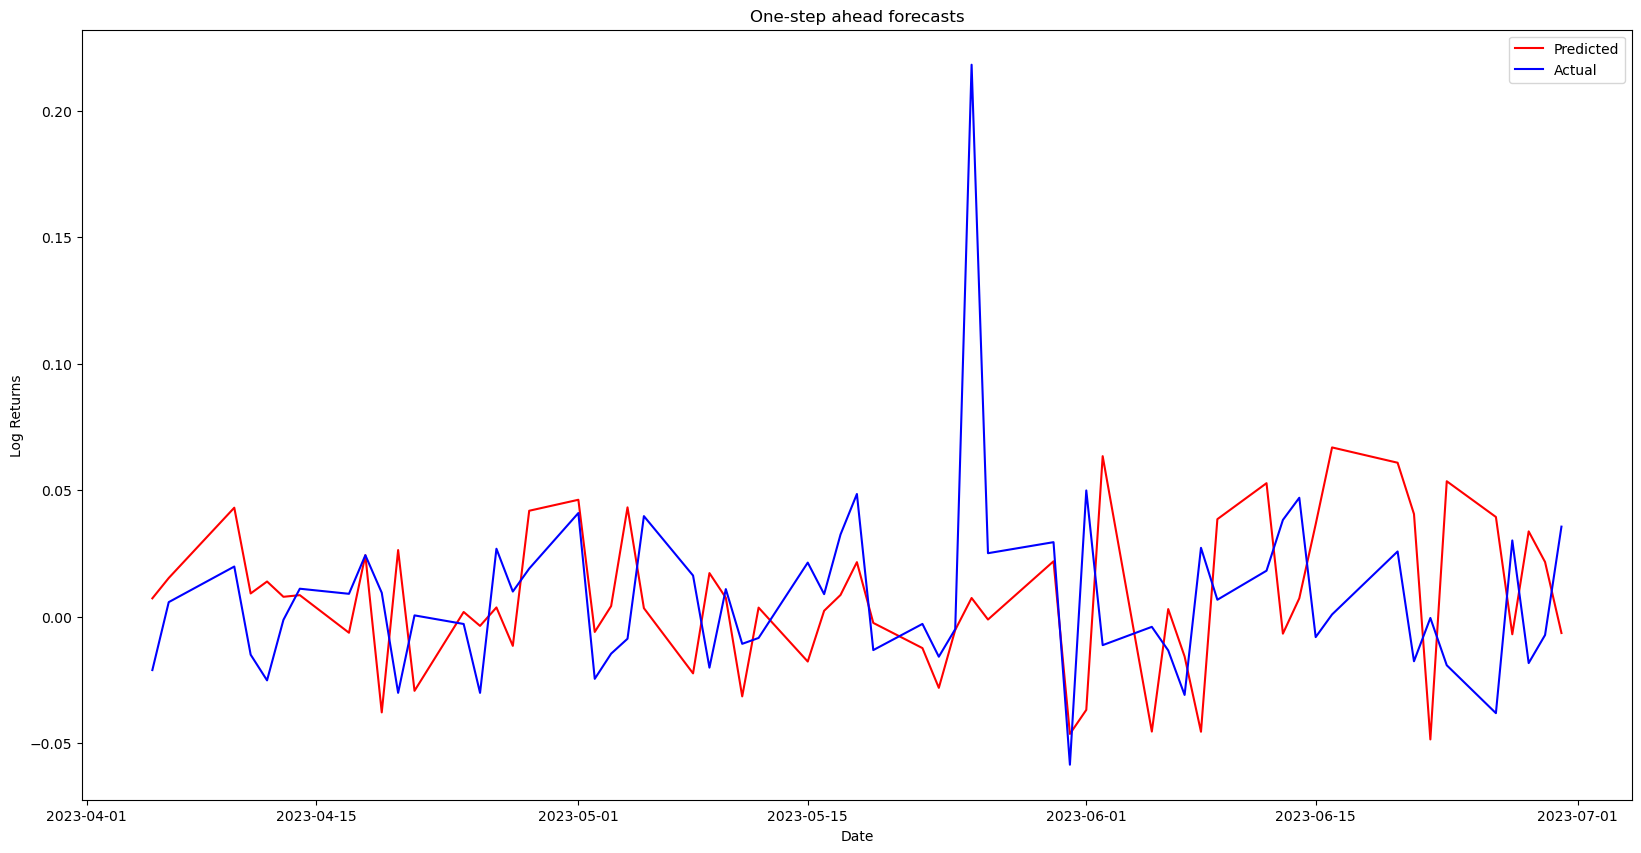

In [24]:
# Plot the forecasts against the actuals
plt.figure(figsize=(20, 10))
plt.plot(test.index.to_timestamp(), forecasts_logret, color='red', label='Predicted')
plt.plot(test.index.to_timestamp(), actuals_logret, color='blue', label='Actual')
plt.title('One-step ahead forecasts')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

Now we convert the log returns into standard returns

In [25]:
forecasts_ret = [np.exp(flogret) -1 for flogret in forecasts_logret]
actuals_ret = [np.exp(alogret) -1 for alogret in actuals_logret]

forecasts_cumulative_ret = [100]
actuals_cumulative_ret = [100]

for t in range(1, len(forecasts_ret)):
    forecasts_cumulative_ret.append(forecasts_cumulative_ret[t-1] + forecasts_ret[t])
    actuals_cumulative_ret.append(actuals_cumulative_ret[t-1] + actuals_ret[t])

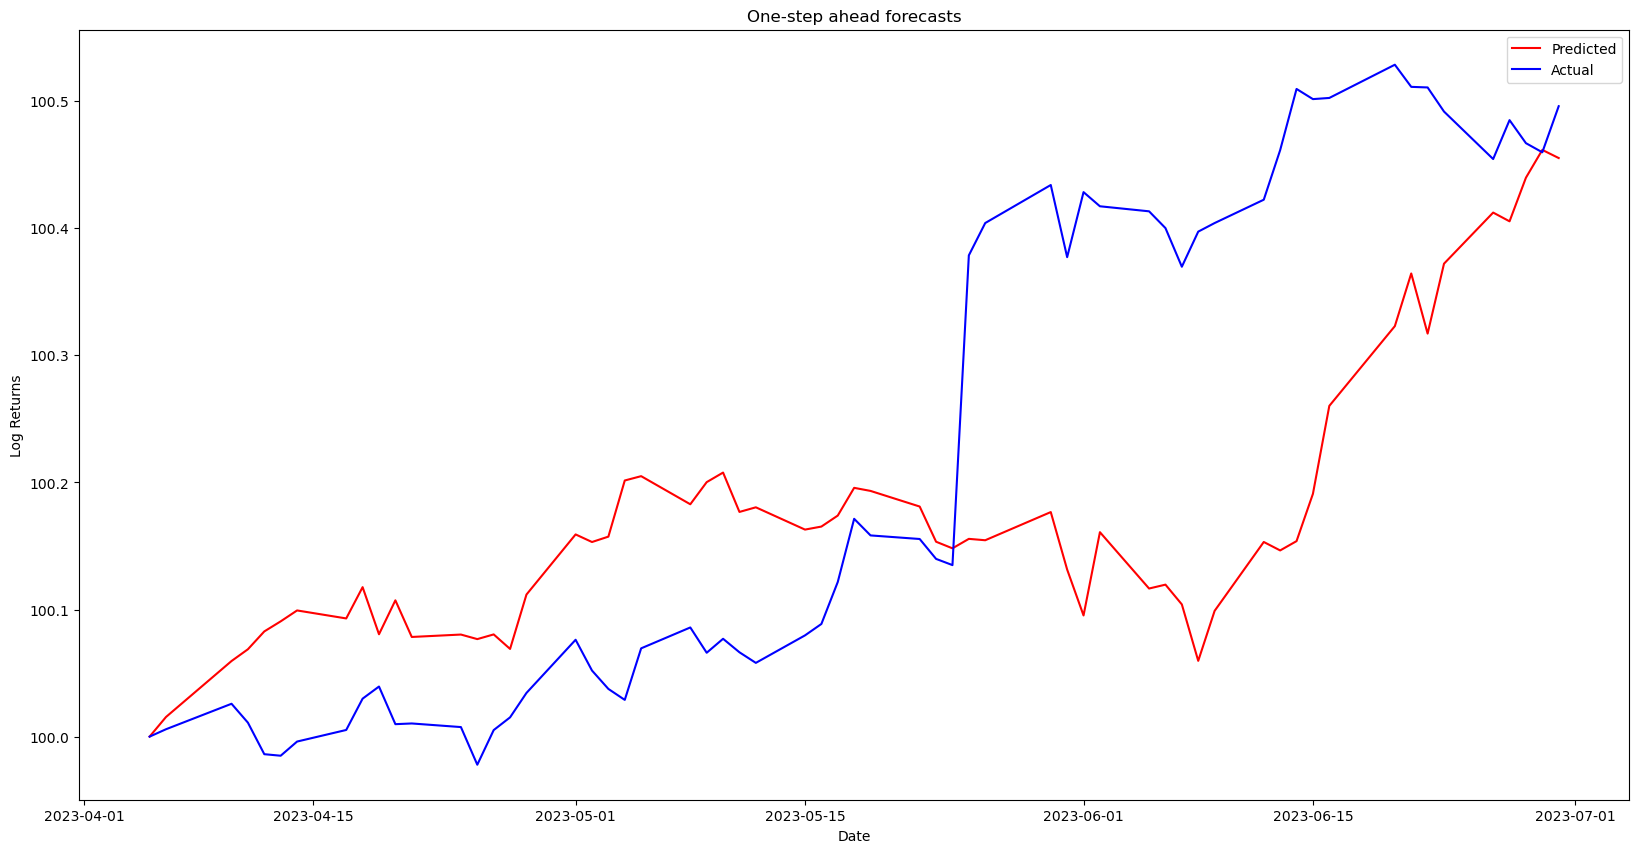

In [26]:
# Plot the forecasts against the actuals
plt.figure(figsize=(20, 10))
plt.plot(test.index.to_timestamp(), forecasts_cumulative_ret, color='red', label='Predicted')
plt.plot(test.index.to_timestamp(), actuals_cumulative_ret, color='blue', label='Actual')
plt.title('One-step ahead forecasts')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

Now we convert the cumulative returns to prices

In [27]:
forecasts_price = [df['NVDA_CLOSE'][-60]]
actuals_price = [df['NVDA_CLOSE'][-60]]

for t in range(1, len(forecasts_ret)):
    forecasts_price.append(forecasts_price[t-1] * (1 + forecasts_ret[t]))
    actuals_price.append(actuals_price[t-1] * (1 + actuals_ret[t]))

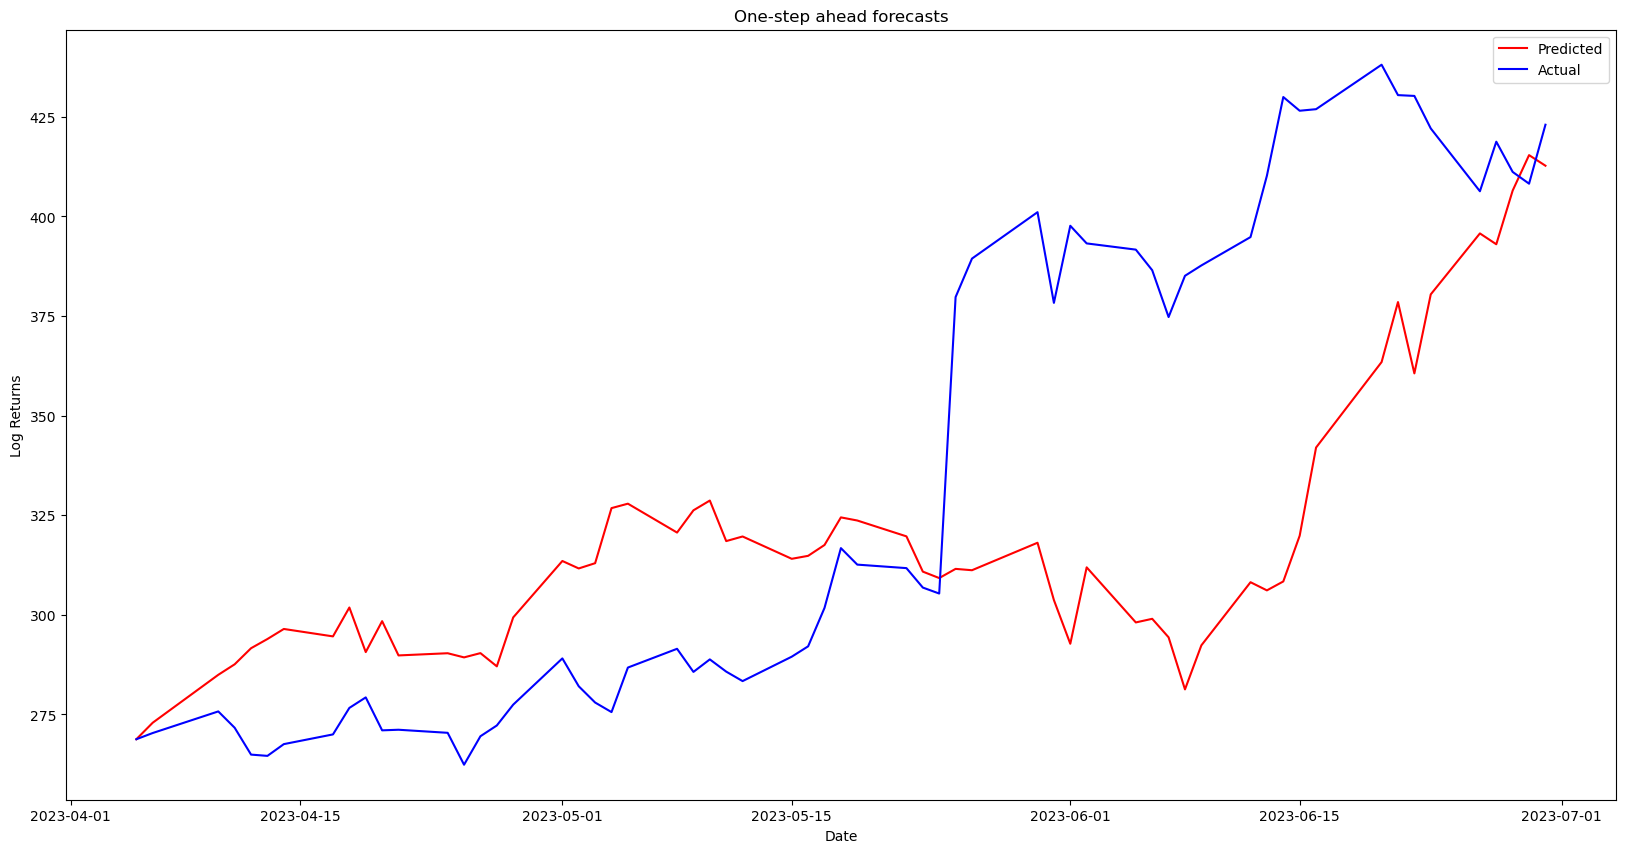

In [28]:
# Plot the forecasts against the actuals
plt.figure(figsize=(20, 10))
plt.plot(test.index.to_timestamp(), forecasts_price, color='red', label='Predicted')
plt.plot(test.index.to_timestamp(), actuals_price, color='blue', label='Actual')
plt.title('One-step ahead forecasts')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

The forecasting results are not exceptional but certainly look like a good starting point. Now we will calculate some quantitative statistics of performance as well.

In [29]:
y_true = np.array(actuals_price)
y_pred = np.array(forecasts_price)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse) # or mse**(0.5)  
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

MAE: 42.219303351730716
MSE: 2895.1698127573923
RMSE: 53.80678221894887
MAPE: 11.904207227744946%


In the context of stock prices, these new results look more reasonable, but the performance of the model still depends on the specific use case.

* MAE (Mean Absolute Error): The MAE of 37.48 means that on average, the model's predictions are off by about $37.48. Given that the stock prices range from around $275 to $425, an average error of $37.48 could be seen as reasonable, depending on your tolerance for error.

* MSE (Mean Squared Error) and RMSE (Root Mean Squared Error): The RMSE of 45.70 is higher than the MAE, which suggests that there are some larger errors that are driving up the average. The RMSE is more sensitive to large errors than the MAE, so this could suggest some outliers in your predictions.

* MAPE (Mean Absolute Percentage Error): The MAPE of around 10.89% indicates that on average, your predictions are off by about 10.89% of the actual stock price. This is a reasonable error rate for a model predicting something as difficult and volatile as stock prices.

## Further Analysis

One thing that particularly stands out when looking at the forecasting results is that the current model is very bad at forecasting large spikes in the data. We already tried to cover fat tails in the residuals by using a student t distribution with our GARCH model. 

The huge spike on 25th May 2023 where the stock price jumped from $305.35 to $379.76 in one day will make a nice example for us to study further and figure out how we can better forecast events like this.

The first step is to simply look up what happened that day to see if there any exogenous variables that might explain the jump.

Looking at news articles in the days leading up to the jump, we see titles such as:

* "Nvidia expects revenue boom as AI drives chip demand", FT.com (24th May 2023). https://www.ft.com/content/6b03dee3-ea79-48dd-b1eb-3df4f029d806
* "NVIDIA Announces Financial Results for First Quarter Fiscal 2024", nvidia.com (24th May 2023). https://nvidianews.nvidia.com/news/nvidia-announces-financial-results-for-first-quarter-fiscal-2024
* "Nasdaq 100 Analysis: Where next for NVIDIA stock ahead of Q1 earnings?", cityindex.com (22nd May 2023). https://www.cityindex.com/en-uk/news-and-analysis/how-will-nvda-stock-impact-the-nasdaq-100-outlook-ahead-of-earnings/
* "Nvidia stock is grossly overvalued: market cap to hit $1 trillion anyway", invezz.com (24th May 2023). https://invezz.com/news/2023/05/24/nvidia-stock-is-grossly-overvalued-market-cap-to-hit-1-trillion-anyway/

It is clear that this jump was a result of the earnings results published by Nvidia after market-close on 24th May 2023, leading to the huge spike in after-hours trading and consequently, continued momentum throughout the trading day on 25th May 2023.

This is strong evidence that expected earnings or sentiment of news headlines on this topic as companies approach earnings season could be strong explanatory variables for forecasting such large spikes.

# Multivariate Model

In [46]:
# Initialise lists to store forecasts and actuals
forecasts_logret_mv = []
actuals_logret_mv = []

# Use the training data to fit the initial model
data_mv = train.copy()
exog_mv = exog_train.copy()

In [47]:
%%capture
for t in range(len(test)):
    # Fit the ARMA model to the data up to this point
    arma_model_mv = sm.tsa.ARIMA(data_mv, exog=exog_mv, order=(best_arma_order[0], 0, best_arma_order[1]))
    arma_res_mv = arma_model_mv.fit()

    # Get the residuals from the ARMA model
    residuals_mv = arma_res_mv.resid

    # Fit the GARCH model on the residuals of the ARMA model
    garch_model_mv = arch_model(residuals_mv*10, vol='Garch', p=best_garch_order[0], q=best_garch_order[1], dist='ged')
    garch_res_mv = garch_model_mv.fit()

    # Make a one-step ahead forecast
    arma_forecast_mv = arma_res_mv.forecast(steps=1, exog=exog_mv.iloc[-1])  # Use the last known exogenous values in forecast
    garch_forecast_mv = garch_res_mv.forecast(start=0)

    # Re-scale the standard deviation of the GARCH forecast
    garch_variance_rescaled_mv = garch_forecast_mv.variance.copy() / 100  # We divide by 100 because variance is in squared units

    # Combine the forecasts
    combined_forecast_mv = arma_forecast_mv[0] + np.sqrt(garch_variance_rescaled_mv.iloc[-1, :]) * np.random.normal(size=1)
    
    # Add the forecast to the list of forecasts
    forecasts_logret_mv.append(combined_forecast_mv[0])

    # Add the actual value to the list of actuals
    actuals_logret_mv.append(test.iloc[t])
    
    # Add the new data point to the data
    data_mv = pd.concat([data_mv, test.iloc[t:t+1]])
    exog_mv = pd.concat([exog_mv, exog_test.iloc[t:t+1]])

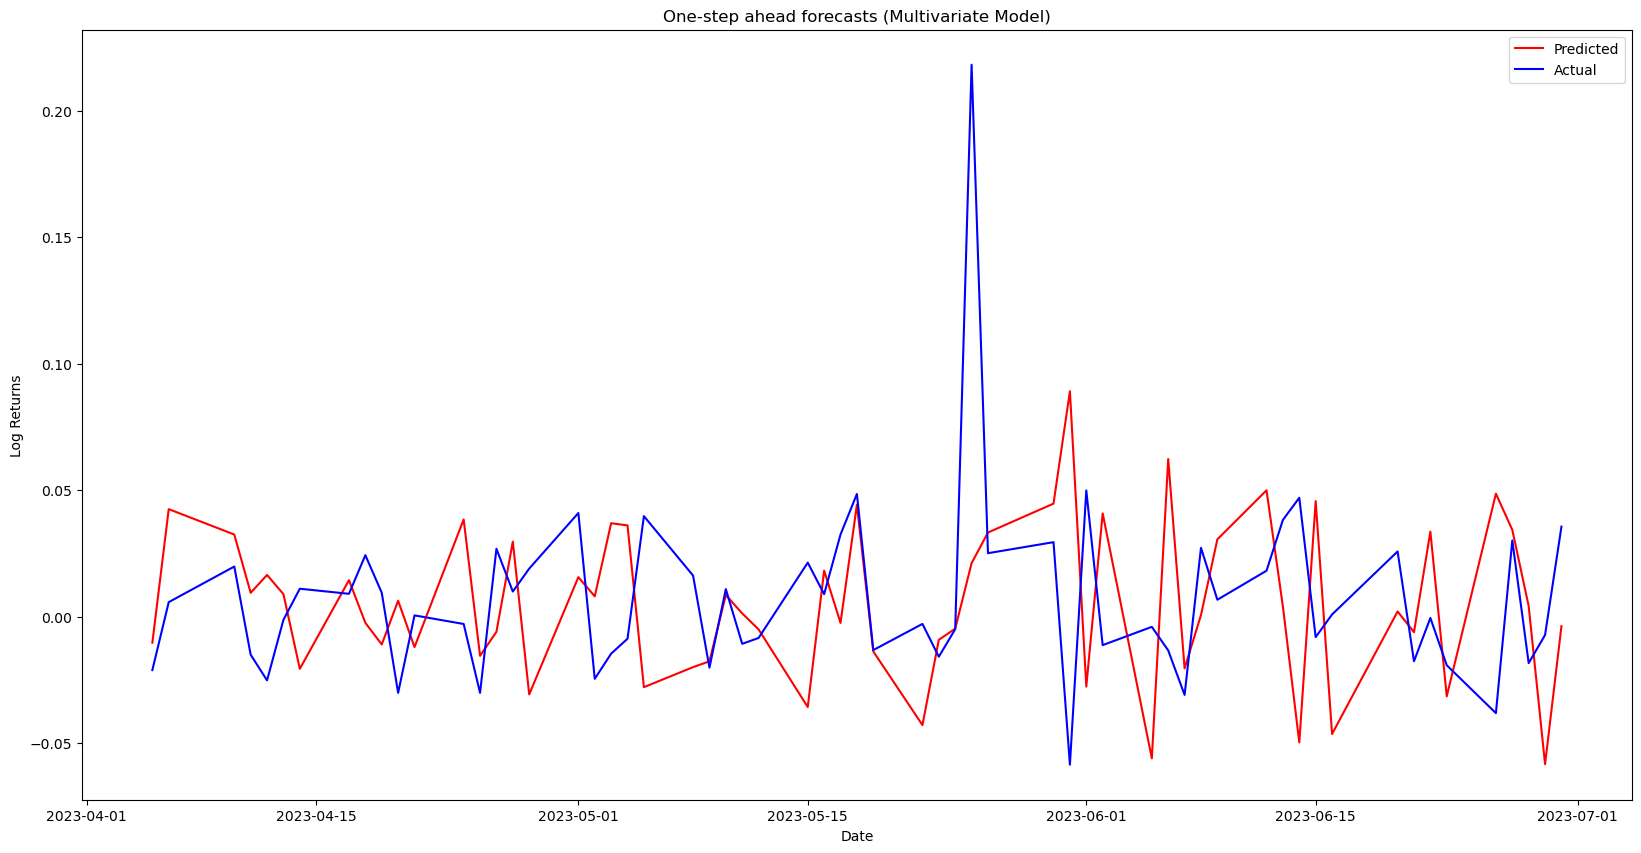

In [48]:
# Plot the forecasts against the actuals
plt.figure(figsize=(20, 10))
plt.plot(test.index.to_timestamp(), forecasts_logret_mv, color='red', label='Predicted')
plt.plot(test.index.to_timestamp(), actuals_logret_mv, color='blue', label='Actual')
plt.title('One-step ahead forecasts (Multivariate Model)')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

In [49]:
forecasts_ret_mv = [np.exp(flogret_mv) -1 for flogret_mv in forecasts_logret_mv]
actuals_ret_mv = [np.exp(alogret_mv) -1 for alogret_mv in actuals_logret_mv]

forecasts_cumulative_ret_mv = [100]
actuals_cumulative_ret_mv = [100]

for t in range(1, len(forecasts_ret_mv)):
    forecasts_cumulative_ret_mv.append(forecasts_cumulative_ret_mv[t-1] + forecasts_ret_mv[t])
    actuals_cumulative_ret_mv.append(actuals_cumulative_ret_mv[t-1] + actuals_ret_mv[t])

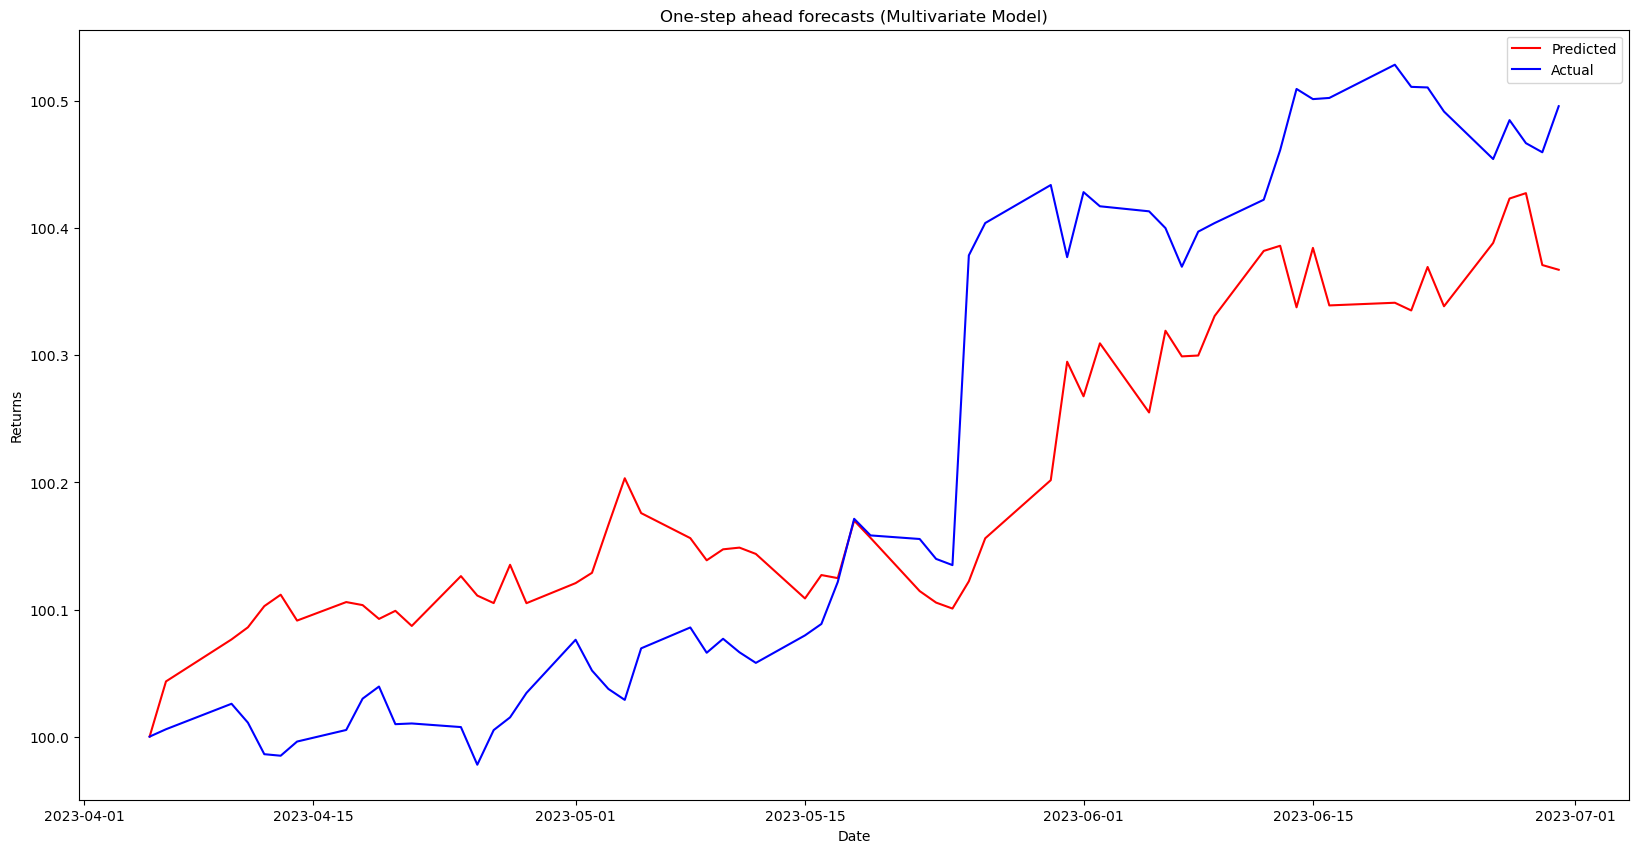

In [50]:
# Plot the forecasts against the actuals
plt.figure(figsize=(20, 10))
plt.plot(test.index.to_timestamp(), forecasts_cumulative_ret_mv, color='red', label='Predicted')
plt.plot(test.index.to_timestamp(), actuals_cumulative_ret_mv, color='blue', label='Actual')
plt.title('One-step ahead forecasts (Multivariate Model)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [51]:
forecasts_price_mv = [df['NVDA_CLOSE'][-60]]
actuals_price_mv = [df['NVDA_CLOSE'][-60]]

for t in range(1, len(forecasts_ret_mv)):
    forecasts_price_mv.append(forecasts_price_mv[t-1] * (1 + forecasts_ret_mv[t]))
    actuals_price_mv.append(actuals_price_mv[t-1] * (1 + actuals_ret_mv[t]))

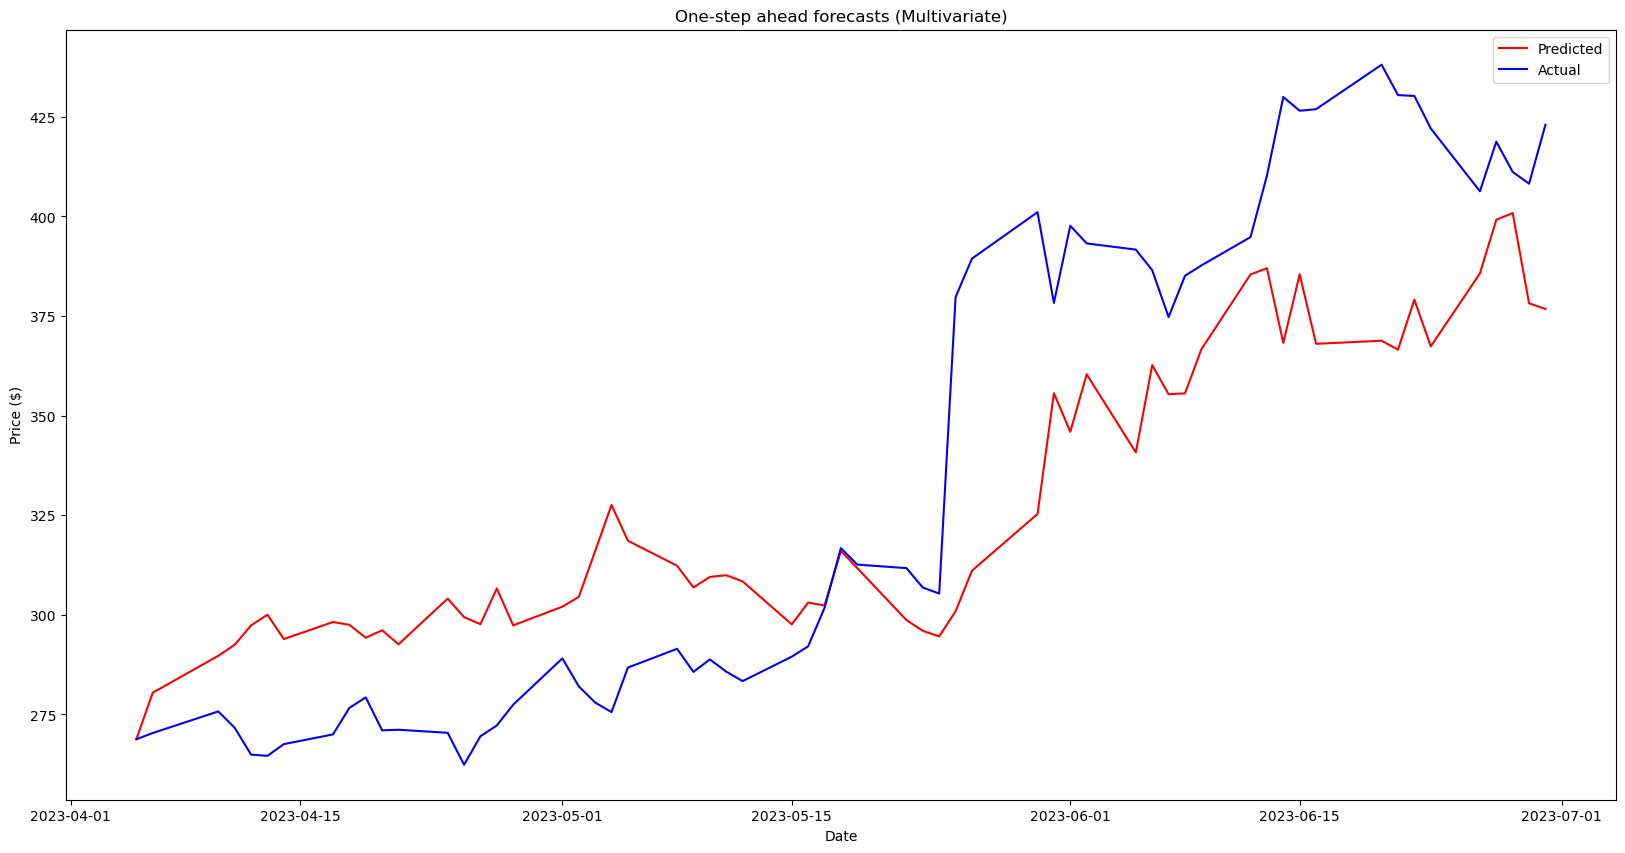

In [52]:
# Plot the forecasts against the actuals
plt.figure(figsize=(20, 10))
plt.plot(test.index.to_timestamp(), forecasts_price_mv, color='red', label='Predicted')
plt.plot(test.index.to_timestamp(), actuals_price_mv, color='blue', label='Actual')
plt.title('One-step ahead forecasts (Multivariate)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

We can see that this multivariate model with exogenous variables is able to respond to the spike much better, but, the response is one day too late. This is because the earnings data relating to this spike becomes available to the model one day after the effect has taken place. As a result, we will attempt to fit a separate model for forecasting the exogenous variables one day ahead and then feed this forecast into the ARIMAX + GARCH forecast.

In [53]:
y_true_mv = np.array(actuals_price_mv)
y_pred_mv = np.array(forecasts_price_mv)

mae_mv = mean_absolute_error(y_true_mv, y_pred_mv)
mse_mv = mean_squared_error(y_true_mv, y_pred_mv)
rmse_mv = np.sqrt(mse) # or mse**(0.5)  
mape_mv = np.mean(np.abs((y_true_mv - y_pred_mv) / y_true_mv)) * 100

print(f'MAE: {mae_mv}')
print(f'MSE: {mse_mv}')
print(f'RMSE: {rmse_mv}')
print(f'MAPE: {mape_mv}%')

MAE: 29.547608214748607
MSE: 1255.6651292098506
RMSE: 53.80678221894887
MAPE: 8.655103607240457%


### Univariate vs Multivariate Comparison

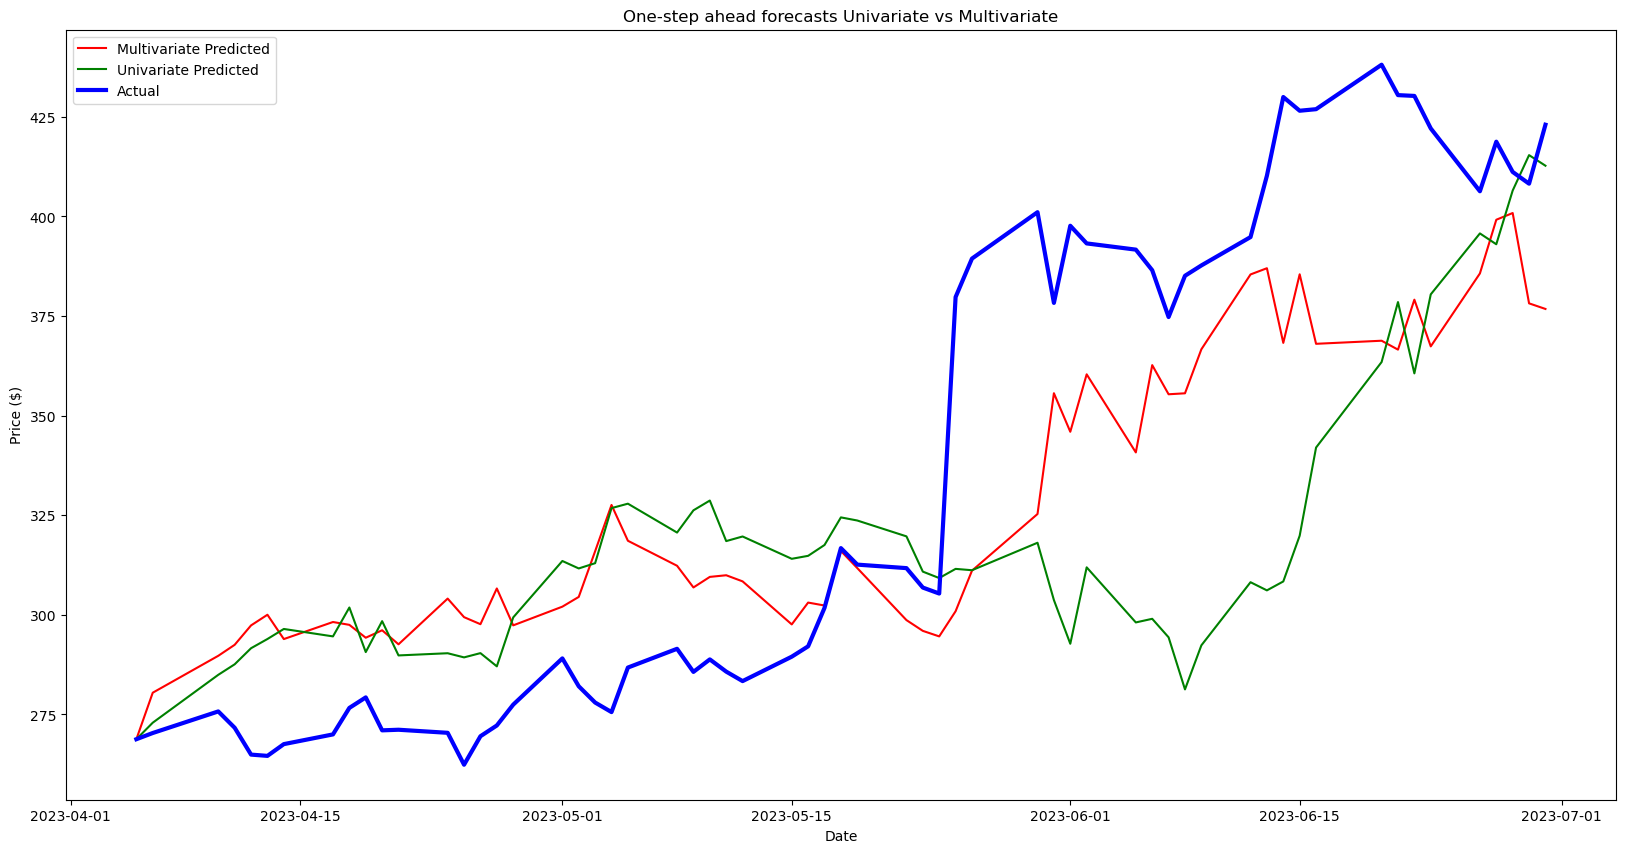

In [57]:
# Plot the forecasts against the actuals
plt.figure(figsize=(20, 10))
plt.plot(test.index.to_timestamp(), forecasts_price_mv, color='red', label='Multivariate Predicted')
plt.plot(test.index.to_timestamp(), forecasts_price, color='green', label='Univariate Predicted')
plt.plot(test.index.to_timestamp(), actuals_price_mv, color='blue', label='Actual', linewidth=3.0)
plt.title('One-step ahead forecasts Univariate vs Multivariate')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()